## Variational Inference

In Bayesian computation we are most likely interested in making inference about hidden variables. From frequentist perspective we are interested in parameters of the population that most likely have generated the sample we observe. In Bayesian perspective, on the other hand, we are interested in what we know about possible values of parameters given the fact that we observe the data at hand.

$$
\begin{align}
P(Z|X) &= \frac{P(X|Z)P(Z)}{P(X)}
        &= \frac{P(X|Z)P(Z)}{\int_Z P(X|Z)P(Z)}
\end{align}
$$

Usually enough, we cannot compute the sum in the denominator easily. Variational inference is a method  for approximating the posterior of the hidden variables. The way we do it is we define a distribution Q with parameters $\phi$ and we try to make this variational distribution as close as possible to the actual posterior of the hidden variables by finding the optimal values of $\phi$.

The difference between two distributions is measured by KL divergence. Thus we are trying to minimize


$$
\begin{align}
KL(q(z|\phi)|p(z|x)) &= \langle \log q(z|\phi) - \log p(z|x) \rangle_{q(z|\phi)} \\
                     &= \langle \log q(z|\phi) - \log p(z, x) + \log p(x) \rangle_{q(z|\phi)} \\
                     &= \langle \log q(z|\phi) - \log p(z, x) \rangle_{q(z|\phi)} + \log p(x)  \geq 0 \\
\end{align}
$$

since KL divergence is always nonnegative. Since \log p(x) does not depend on q, we aim to maximize $\langle \log q(z|\phi) - \log p(z, x) \rangle$ or minimize its negative. This value is called evidence lower bound (ELBO) since:

$$
\begin{align}
    \log p(x)  \geq \langle - \log q(z|\phi) + \log p(z, x)  \rangle_{q(z|x)}
\end{align}
$$





### A simple example (Beta - Bernoulli)

Let us demonstrate this idea on a simple example.

$$
\begin{align}
\pi &\sim B(\alpha, \beta) \\
x_i &\sim BE(\pi)
\end{align}
$$

Let our variational distribution be $q(z|\phi) = q(\pi|a,b) = B(a, b)$. Then ELBO is:

$$
\begin{align}
\mathcal{L} &= \langle -(a-1)\log \pi - (b-1)\log (1- \pi) + \log B(a, b) +(\alpha -1)\log \pi + (\beta-1)\log (1-\pi) - \log B(\alpha, \beta) + \sum_i x_i \log \pi + (1 - x_i) \log (1-\pi)    \rangle_{q(\pi|a,b)} \\
            &= \langle (\alpha - a + \sum_i x_i)\log \pi + (\beta - b + \sum_i (1 - x_i))\log (1- \pi) \rangle_{q(\pi|a,b)} + \log B(a, b) - \log B(\alpha, \beta)  \\
            &= (\alpha - a + \sum_i x_i)\langle \log \pi \rangle_{q(\pi|a,b)} + (\beta - b + \sum_i (1 - x_i))\langle\log (1- \pi)\rangle_{q(\pi|a,b)}  + \log B(a, b) - \log B(\alpha, \beta)  \\
            &= (\alpha - a + \sum_i x_i)(\psi(a)-\psi(a + b)) + (\beta - b + \sum_i (1 - x_i))(\psi(b)-\psi(a + b))  + \log B(a, b) - \log B(\alpha, \beta)  \\
            &= (\alpha - a + \sum_i x_i)(\psi(a)-\psi(a + b)) + (\beta - b + \sum_i (1 - x_i))(\psi(b)-\psi(a + b))  + \log B(a, b) - \log B(\alpha, \beta)  \\
\end{align}
$$




When we take the derivative of the ELBO with respect to a and b:

$$
\begin{align}
\frac{\partial \mathcal{L}}{\partial a} &= (\alpha - a + \sum_i x_i)(\psi(a) - \psi(a + b))' - (\beta - b + \sum_i (1 - x_i))\psi'(a + b)\\
\frac{\partial \mathcal{L}}{\partial b} &= - (\alpha - a + \sum_i x_i)\psi'(a + b) - (\beta - b + \sum_i (1 - x_i))(\psi(a) - \psi(a + b))'
\end{align}
$$

Both equations equal 0 when:

$$
\begin{align}
a &= \alpha + \sum_i x_i \\
b &= \beta + \sum_i (1 - x_i)
\end{align}
$$

Thus, 
$$
q(\pi|a,b) = B(\alpha + \sum_i x_i, \beta + \sum_i (1 - x_i))
$$

### Implementation for the beta-binomial example

Let us quickly implement the simple example above:

In [79]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import beta
from scipy.stats import bernoulli


def plot_beta(b, pi, title=""):
    x = np.linspace(0,1,100)
    y = b.pdf(x)
    fig, ax = plt.subplots()
    ax.plot(x,y, label="beta")
    ax.set_title(title)
    ax.axvline(pi, c="black", label="pi")
    ax.legend()
    ax.set_xlim(0,1)
    return fig, ax

def generate_x(N, pi):
    x = bernoulli(pi).rvs(size=N)
    return x

Setting the alpha and beta hyperparameters for the prior distribution for pi, and the number of samples to be drawn from the resulting Bernoulli distribution.

In [80]:
alpha_par = 1
beta_par = 1
N = 100

In [82]:
b_prior = beta(alpha_par, beta_par)
pi = b_prior.rvs()

Plotting the prior distribution along with the actual value of the pi.

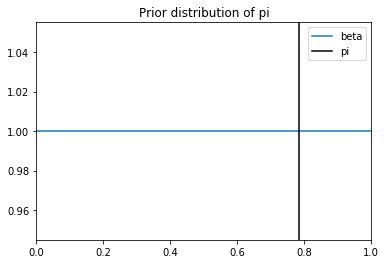

In [83]:
fig, ax = plot_beta(b_prior, pi, "Prior distribution of pi")

Generating samples from the resulting Bernoulli distribution:

In [88]:
x = generate_x(N, pi)

Finding the parameters for the posterior distribution of pi using variational inference

In [85]:
a_par = alpha_par + x.sum()
b_par = beta_par + N - x.sum()

In [86]:
b_posterior = beta(a_par, b_par)

Plotting the posterior distribution of pi along with the actual value of pi. The posterior distribution's mode and expected value are much closer to the actual value then the prior's were.

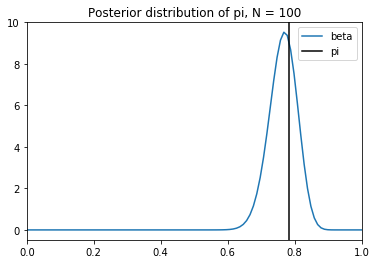

In [89]:
fig, ax = plot_beta(b_posterior, pi, "Posterior distribution of pi, N = {}".format(N))

### Mean field variational inference

Let us now focus on another example. A mixture of Gaussians. This example is from Blei's review.

Let us imagine a Bayesian mixture of K Gaussians, where N samples are produced.

The generative process is as below:

$$
\begin{align}
 \mu_k &\sim \mathcal{N}(0, \sigma^2) &k = 1 ... K \\
 c_i  &\sim \text{Categorical}(1/K ... 1/ K) &i = 1 ... N \\
 x_i  &\sim \mathcal{N}(c_i^\intercal \pmb{\mu}, 1) &i = 1 ... N \\
\end{align}
$$
Here, we want to obtain $ p(\pmb{\mu}, \pmb{c} | \pmb{x} )$ but we cannot since we cannot compute $p(\pmb{x})$. Thus we need to approximate this posterior distribution using a variational distribution $q(\pmb{z})$ as above. Here we are assuming to select our model based on ELBO. Some argue that this is not justified and use log predictive distribution with cross-validation.

The complexity of the optimization increases as the complexity of q increases. Therefore, a class of variational inference models make the following assumption:

$$
q(\pmb{z}) = \prod_i q_i(z_i)
$$

where the latent variables are assumed to be independent of each other. This is a simplifying assumption that makes the computation more tractable but also decreasing the capacity of q to model p. The mean-field approximating distribution for the mixture of Gaussians defined above is:

$$
q(\pmb{\mu}, \pmb{c}) = \prod_k q(\mu_k | m_k, s_k^2) \prod_i q(c_i|\varphi_i)
$$

Now the problem has become an optimization problem. We solve this optimization problem with coordinate ascent variational inference algorithm. In this algorithm, we optimize variational distributions one by one, holding all other distributions constant. As verified by Blei, the optimization is conducted iteratively by setting $q_i^*(z_i)$ such that:

$$
q_i^*(z_i) \propto \exp (\mathbb{E}_{-j}[p(z_j|\pmb{z}_{-j}, \pmb{x})])
$$

VI can be sensitive to initialization. When optimizing with VI, it might sometimes be more desirable to calculate average log predictive of a validation set than calculating ELBO of the whole dataset. Moreover, it is a good practice to work with logs of probabilities and use the likes of log-sum-exp trick when applicable in order to avoid underflow problems.





Let us now write the ELBO for the mixture of Gaussians example:
$$
\begin{align}
ELBO(\pmb{m},\pmb{s^2}, \pmb{\varphi}) = \sum_k\mathbb{E}[\log p(\mu_k); m_k, s^2_k] + \sum_i\mathbb{E}[\log p(c_i); \varphi_i] + \sum_i\mathbb{E}[\log p(x_i|c_i, \pmb{\mu}); \pmb{m}, \pmb{s}^2, \varphi_i] - \sum_k\mathbb{E}[\log q(\mu_k|m_k, s^2_k)] - \sum_i\mathbb{E}[\log q(c_i|\varphi_i)])
\end{align}
$$

### The variational density for mixture component assignments and component means

$$q_i^*(c_i|\varphi_i) \propto \exp (\log p(c_i) + \mathbb{E}[\log p(x_i|c_i, \pmb{\mu}); \pmb{m}, \pmb{s}^2])$$

Since in our example c_i's are equal, \log p(c_i) is constant. Let us examine the second term more closely. Using the expression $p(x_i|c_i, \pmb{\mu}) = \prod_{i,k} p(x_i|\mu_k)^{c_{ik}}$, skipping a few lines of derivation:

$$
\begin{align}
\mathbb{E}[\log p(x_i|c_i, \pmb{\mu}); \pmb{m}, \pmb{s}^2] & = \sum_k c_{ik} (\mathbb{E}[\mu_k; m_k, s^2_k]x_i - \mathbb{E}[\mu^2_k; m_k, s^2_k] / 2) + \text{const}
\end{align}
$$

Thus:
$$
\varphi_{i,k} \propto \exp( \mathbb{E}[\mu_k; m_k, s^2_k]x_i - \mathbb{E}[\mu^2_k; m_k, s^2_k] / 2)
$$

A similar calculation reveals the following update equations for $q(\mu_k)$:

$$
\begin{align}
m_k &= \frac{\sum_i \varphi_{ik} x_i}{1/\sigma^2 + \sum_i \varphi_{ik}} \\
s^2_k &= \frac{1}{1/\sigma^2 + \sum_i \varphi_{ik}}
\end{align}
$$

### Computing the ELBO

Let us rewrite the ELBO:

$$
\begin{align}
ELBO(\pmb{m},\pmb{s^2}, \pmb{\varphi}) = \sum_k\mathbb{E}[\log p(\mu_k); m_k, s^2_k] + \sum_i\mathbb{E}[\log p(c_i); \varphi_i] + \sum_i\mathbb{E}[\log p(x_i|c_i, \pmb{\mu}); \pmb{m}, \pmb{s}^2, \varphi_i] - \sum_k\mathbb{E}[\log q(\mu_k|m_k, s^2_k)] - \sum_i\mathbb{E}[\log q(c_i|\varphi_i)])
\end{align}
$$

Now let us write each term more explicitly:
$$
\begin{align}
\sum_k^K\mathbb{E}[\log p(\mu_k); m_k, s^2_k]  &=  \sum_k^K \log(\frac{1}{\sqrt{2\pi\sigma^2_0}}) -\frac{m_k^2 + s_k^2}{2\sigma^2_0}  \\
\sum_k^K\mathbb{E}[\log p(c_i); \varphi_i]  &= \sum_i^N \sum_k^K \varphi_{ik}\log(1/K) = -\log(K) \\
\sum_i^N\mathbb{E}[\log p(x_i|c_i, \pmb{\mu}); \pmb{m}, \pmb{s}^2, \varphi_i] &= \sum_i \sum_k \varphi_{ik} (\log(\frac{1}{\sqrt{2\pi}}) -\frac{1}{2}(x_i^2 -2m_k x_i + m^2_k +s^2_k) ) \\
\sum_k^K\mathbb{E}[\log q(\mu_k|m_k, s^2_k)] &= \sum_k^K \log(\frac{1}{\sqrt{2\pi e s^2_k}}) \\
\sum_i^N\mathbb{E}[\log q(c_i|\varphi_i)] &= \sum_i^N \sum_k^K \varphi_{ik}\log(\varphi_{ik}) 
\end{align}
$$

### Implementation for the mixture of Gaussians example

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.stats import multinomial

def plot_mog(x, means, N, title=""):
    y = np.repeat(0, N)
    fig, ax = plt.subplots()
    ax.scatter(x, y, label="x", s=7)
    ax.set_title(title)
    for mean in means:
        ax.axvline(mean, c="black")
    ax.legend()
    return fig, ax

In [26]:
mu_0 = 0
sigma_0 = 10
sigma_k = 1
N = 100
K = 3

In [27]:
means = norm(mu_0, sigma_0).rvs(size=3)
#means = np.array([-1.77768294,  2.86416801, -4.07905112])

In [28]:
multi = multinomial(n=1,p=np.repeat(1./K, K))

In [29]:
c = multinomial(n=1,p=np.repeat(1./K, K)).rvs(N)
x = []
for i in range(N):
    c_i = c[i]
    mu_k = c_i @ means
    x_i = norm(mu_k, sigma_k).rvs()
    x.append(x_i)
x = np.array(x)

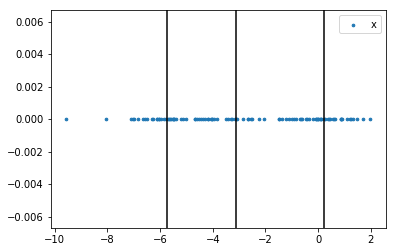

In [30]:
fig, ax = plot_mog(x,  means, N)

Now for the variational inference

In [31]:
def normalize(varphi):
    return varphi / varphi.sum(axis=1).reshape(N, 1)

def eval_elbo():
    pass

def avg_log_predictive(x, N, K, m):
    sum_i = 0.
    for i in range(N):
        sum_k = 0.
        for k in range(K):
            sum_k += norm(m[k], 1.).pdf(x[i])
        sum_k /= K
        sum_i += np.log(sum_k)
    avg_log_predictive = sum_i / N
    return avg_log_predictive

def plot_predictive(x, K, m, title=""):
    x_dummy = np.linspace(-10,10,1000)
    sum_k = np.zeros((1000,3))
    for k in range(K):
        sum_k[:, k] = norm(m[k], 1.).pdf(x_dummy)
    #log_pred = np.log(sum_k.mean(axis=1))
    #y = log_pred - log_pred.min()
    y = sum_k.mean(axis=1)
    fig, ax = plt.subplots()
    ax.set_title(title)
    ax.scatter(x, np.repeat(0, N), label="x", s=7)
    ax.plot(x_dummy, y, label="-log_pred")
    return fig, ax

def compute_elbo(x, m, s, varphi, sigma_0, K, N):
    exp_p_m = K*np.log(1/(np.sqrt(2*np.pi*sigma_0))) - (1/(2*sigma_0))*(m**2 + s).sum()
    exp_p_c = -np.log(K)
    exp_p_x = 0
    for i in range(N):
        for k in range(K):
            exp_p_x += varphi[i,k]*(np.log(1/(np.sqrt(2*np.pi))) - 0.5*(x[i]**2 - 2*m[k]*x[i] + m[k]**2 + s[k]))
    exp_q_m = (np.log(1/np.sqrt(2*np.pi*np.e*s))).sum()
    exp_q_c = 0
    for i in range(N):
        for k in range(K):
            exp_q_c += varphi[i,k] * np.log(varphi[i,k])
    elbo = exp_p_m + exp_p_c + exp_p_x - exp_q_m - exp_q_c
    return elbo

def plot_elbo_alp(elbo, avg_log_pred):
    n_epochs = len(elbo)
    fig, axes = plt.subplots(1, 2)
    axes[0].plot(range(n_epochs), elbo)
    axes[0].set_title("ELBO")
    axes[1].plot(range(n_epochs), avg_log_pred)
    axes[1].set_title("Avg. Log Pred.")
    return fig, axes

In [32]:
#initializing the parameters for the variational distributions
varphi = np.random.rand(N, K)
varphi = normalize(varphi)
m = np.random.uniform(-1, 1, size=K)
s = np.repeat(1., K)

In [33]:
max_n_epochs = 100
elbo = []
avg_log_pred = []
mean_diffs = []
for t in range(max_n_epochs):
    #component assignments
    for i in range(N):
        for k in range(K):
            varphi[i, k] = np.exp((m[k]*x[i] - m[k]**2 - s[k])/2)
    varphi = normalize(varphi)
    m_old = m.copy()
    for k in range(K):
        m[k] = ((varphi[:,k]*x).sum())/((1/sigma_0) + varphi.sum(axis=0)[k])
        s[k] = 1/((1/sigma_0) + varphi.sum(axis=0)[k])
    mean_diffs.append(np.dot(np.array(m_old) - np.array(m), np.array(m_old) - np.array(m)))
    if np.dot(np.array(m_old) - np.array(m), np.array(m_old) - np.array(m)) < 0.000001:
        break
    elbo.append(compute_elbo(x, m, s, varphi, sigma_0, K, N))
    avg_log_pred.append(avg_log_predictive(x, N, K, m))
elbo = np.array(elbo)
avg_log_pred = np.array(avg_log_pred)
mean_diffs = np.array(mean_diffs)

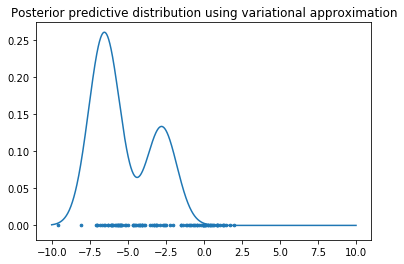

In [34]:
fig, ax = plot_predictive(x, K, m, title="Posterior predictive distribution using variational approximation")

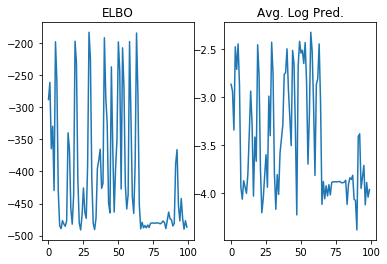

In [35]:
fig, axes = plot_elbo_alp(elbo, avg_log_pred)

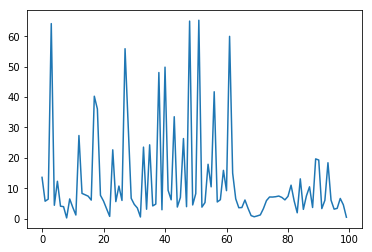

In [36]:
plt.plot(range(len(mean_diffs)), mean_diffs)

### VI in exponential families

Mean-field VI in exponential families is especially easy. If each complete conditional for hidden variables is in the exponential families as in the case of Bayesian mixture of Gaussians, then mean-field updates are very easy to derive and the algorithm is easily scalable. Let us write the complete conditional for variable $z_j$ in the canonical exponential form:

$$
p(z_j|\pmb{z_{-j}}, \pmb{x}) = h(z_j)\exp(\eta_j(\pmb{z_{-j}}, \pmb{x})^\intercal z_j - a(\eta_j(\pmb{z_{-j}}, \pmb{x})))
$$

So considering the mean-field update equations:

$$
\begin{align}
q(z_j)  &\propto \mathbb{E}_{q(\pmb{z}_{-j})}[p(z_j|\pmb{z_{-j}}, \pmb{x})] \\
        &\propto h(z_j)\exp(\eta_j(\pmb{z_{-j}}, \pmb{x})^\intercal z_j
\end{align}
$$

This shows that the optimal parametric form of the variational factors to be in the same form as the full posterior distributions of the complete conditionals of the factors. Let $\nu_j$ be the parameters for the variational distribution of the j'th factor. The relation above implies that:

$$
\nu_j \propto \mathbb{E}[\eta_j(\pmb{z_{-j}}, \pmb{x})^\intercal z_j]
$$

This facilitates the derivation of update equations for CAVI ini exponential families.

### Conditional conjugacy

Conditionally conjugate models are a specific case of exponential family models. They include global and local latent variables. When the priors are chosen so that the priors for the parameters are in the same family as the complete conditional of each of them, the parameters of the complete conditionals are very easy to derive in a CAVI setting.

### Stochastic variational inference

To be completed.

### Variational auto-encoding Bayes

In certain cases we cannot conduct mean-field variational inference since we cannot calculate expectations with regard to the variational distributions. Moreover, it can also be the case that the Monte Carlo estimator for the gradient has too much variance and does not converge.

In these cases we can find an alternative way to optimize the evidential lower bound.



### Black box variational inference